In [150]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

from sklearn.model_selection import train_test_split

In [151]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sub = pd.read_csv('./sample_submission.csv')

In [152]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
def imshow(img):
    npimg = img.to_numpy().reshape((28,28))
    plt.gray()
    plt.imshow(npimg, cmap='gray')
    plt.show()


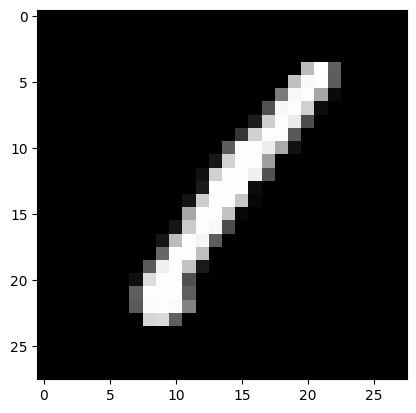

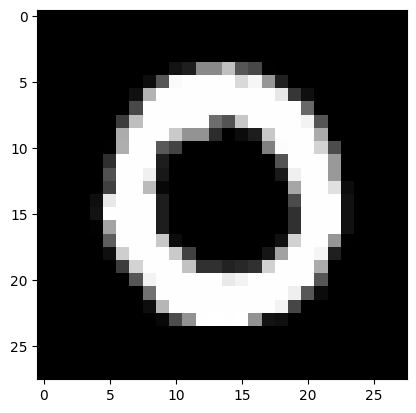

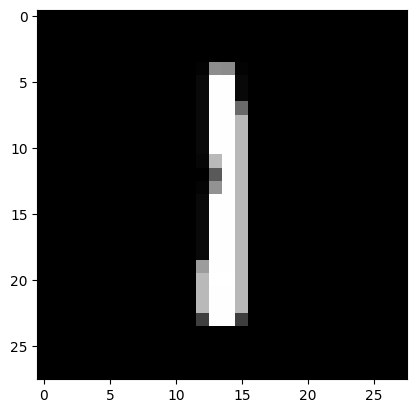

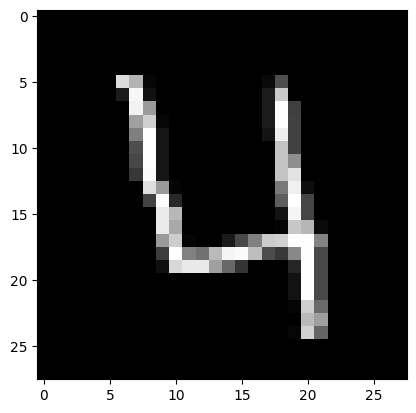

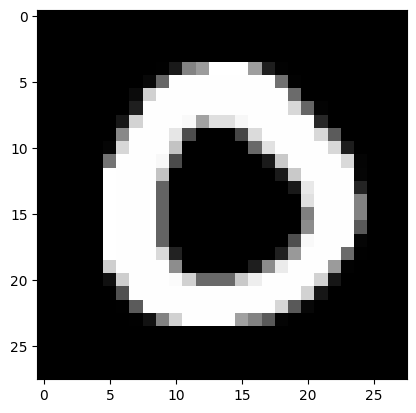

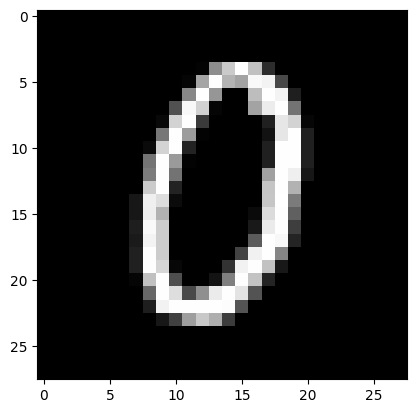

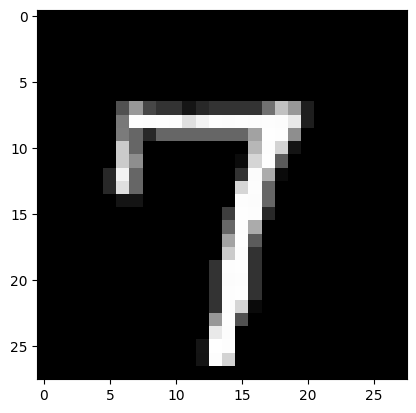

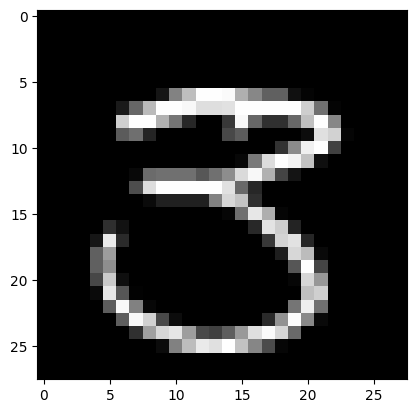

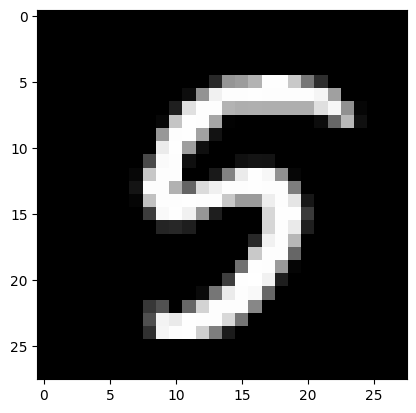

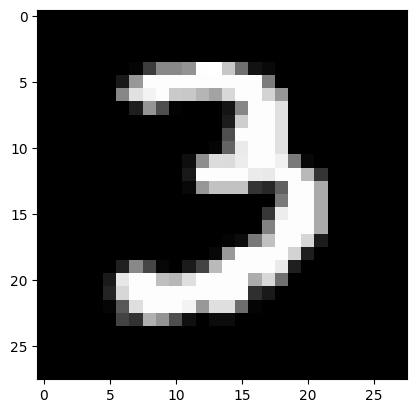

In [155]:
# visualize some images
for i in range(10):
    imshow(train.iloc[i, 1:])


In [156]:
y_train = train.label.values

# divide by 255 to normalize data 0-255 -> 0-1
X_train = train.loc[:, train.columns != 'label'].values / 255

X_train.shape, y_train.shape

((42000, 784), (42000,))

In [157]:
y_train = torch.Tensor(y_train).type(torch.LongTensor)

X_train = X_train.reshape(-1, 1, 28, 28)
X_train.shape

(42000, 1, 28, 28)

In [158]:
Transform = transforms.Compose(
    [transforms.ToTensor()]
)

In [159]:
from GetData import GetData

In [160]:
dataset_train = GetData(X_train, y_train, Transform)

batch_size = 64
generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [161]:
next(iter(generator_train))[0].shape

torch.Size([64, 1, 28, 28])

In [162]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(p=0.3)
            
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop2 = nn.Dropout(p=0.4)
    
        self.fc1 = nn.Linear(128 * 4 * 4, 64)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.fc2 = nn.Linear(64, 32)
        self.drop4 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.drop3(F.relu(self.fc1(x)))
        x = self.drop4(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [163]:
gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if gpu else 'cpu')
print('device:', device)

device: cuda:0


In [164]:
net = Net()
if(gpu):
    net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [165]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [166]:
net.train()
no_epochs = 25
for epoch in range(no_epochs):
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(generator_train):
        if (gpu):
            inputs, labels = data[0].to(device), data[1].to(device)
        else:
            inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        reporting_interval = 100
        running_loss += loss.item()
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size
        if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / reporting_interval, running_accuracy / reporting_interval))
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')

[1,   100] loss: 1.668, accuracy: 0.403
[1,   200] loss: 0.766, accuracy: 0.748
[1,   300] loss: 0.536, accuracy: 0.827
[1,   400] loss: 0.426, accuracy: 0.873
[1,   500] loss: 0.368, accuracy: 0.889
[1,   600] loss: 0.318, accuracy: 0.907
[2,   100] loss: 0.278, accuracy: 0.918
[2,   200] loss: 0.253, accuracy: 0.930
[2,   300] loss: 0.213, accuracy: 0.938
[2,   400] loss: 0.235, accuracy: 0.941
[2,   500] loss: 0.208, accuracy: 0.941
[2,   600] loss: 0.198, accuracy: 0.945
[3,   100] loss: 0.185, accuracy: 0.946
[3,   200] loss: 0.178, accuracy: 0.953
[3,   300] loss: 0.165, accuracy: 0.955
[3,   400] loss: 0.159, accuracy: 0.957
[3,   500] loss: 0.163, accuracy: 0.954
[3,   600] loss: 0.174, accuracy: 0.953
[4,   100] loss: 0.138, accuracy: 0.961
[4,   200] loss: 0.138, accuracy: 0.963
[4,   300] loss: 0.146, accuracy: 0.959
[4,   400] loss: 0.136, accuracy: 0.964
[4,   500] loss: 0.128, accuracy: 0.965
[4,   600] loss: 0.146, accuracy: 0.959
[5,   100] loss: 0.114, accuracy: 0.966


In [171]:
X_test = (test.values/255).reshape(-1, 1, 28, 28)
X_test.shape

(28000, 1, 28, 28)

In [174]:
net.eval()
with torch.no_grad():
    if (gpu):
        outputs = net(torch.Tensor(X_test).to(device))
    else:
        outputs = net(torch.Tensor(X_test))
    preds = torch.max(outputs.data, 1)
    preds2 = outputs.cpu().argmax(dim=1)
    sub['Label'] = preds2

In [175]:
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [176]:
sub.to_csv('./submission.csv', index=False)